# MobileNet BUILD

# 1. Library Import

In [3]:
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
import pandas as pd
import csv
import shutil
import json
from sklearn import metrics as skmet
from skimage import morphology
from skimage import measure
from skimage import exposure

### Tensorflow 2.0 ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K

# 2. Module Function

## 2.1. Keras applications

In [3]:
model = tf.keras.applications.mobilenet.MobileNet(
    input_shape=None, alpha=1.0, depth_multiplier=1, dropout=0.001,
    include_top=True, weights='imagenet', input_tensor=None, pooling=None,
    classes=1000, classifier_activation='softmax')
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

## 2.2 Manual Build

In [4]:
class MobileBlock2D:
    def conv_block(self, lr_io, filts, ker_size, fstr):
        # layer blcok
        lr_conv = layers.Conv2D(filts, ker_size, fstr, activation=None,
                                    padding='same', kernel_initializer='he_normal')(lr_io)
        lr_conv = layers.BatchNormalization(axis=-1)(lr_conv)
        lr_conv = layers.Activation('relu')(lr_conv)
        return lr_conv
    def ds_conv_block(self, lr_io, filts, fstr, pad='same'):
        # layer blcok
        lr_conv = layers.DepthwiseConv2D(3, fstr, activation=None, padding=pad, depthwise_initializer='he_normal')(lr_io)
        lr_conv = layers.BatchNormalization(axis=-1)(lr_conv)
        lr_conv = layers.Activation('relu')(lr_conv)
        lr_conv = layers.Conv2D(filts, 1, 1)(lr_conv)
        lr_conv = layers.BatchNormalization(axis=-1)(lr_conv)
        lr_conv = layers.Activation('relu')(lr_conv)
        return lr_conv
    def gap_block(self, lr_io, den_count, drop_rate):
        lr_gap = layers.GlobalAveragePooling2D()(lr_io)
        lr_dense = layers.Dense(den_count, activation='relu')(lr_gap)
        lr_drop = layers.Dropout(drop_rate)(lr_dense)
        return lr_drop

mb = MobileBlock2D()

In [5]:
def mobilenet_2D(par_dic):
    # parameters
    input_size = par_dic['inputs']
    channel_num = par_dic['channels']
    dens_num = par_dic['dens_num']
    drop_rate = par_dic['drop_rate']
    output_count = par_dic['output_count']
    output_act = par_dic['output_act']
    # code block
    inputs = layers.Input(shape=(input_size, input_size, channel_num))
    conv = mb.conv_block(inputs, 32, 3, 2)
    for i in range(3):
        conv = mb.ds_conv_block(conv, 64 * (2**i), 1) 
        conv = mb.ds_conv_block(conv, 128 * (2**i), 2)
    for i in range(5):
        conv = mb.ds_conv_block(conv, 512, 1) 
    # for i in range(2):
    conv = mb.ds_conv_block(conv, 1024, 2)
    conv = mb.ds_conv_block(conv, 1024, 1)
    gap = mb.gap_block(conv, dens_num, drop_rate)
    outputs = layers.Dense(output_count, activation=output_act)(gap)
    model = Model(inputs, outputs)
    return model

mobilenet_param = {'inputs': 224,
                'channels': 3,
                'dens_num': 1000,
                'drop_rate': 0.5,
                'output_count': 1000,
                'output_act': 'softmax'}
model = mobilenet_2D(mobilenet_param)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 112, 112, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 32)      0     

# 3. Dataset

In [13]:
(x_train, y_train), (x_test, y_test)=keras.datasets.mnist.load_data(path='minist.npz')

In [14]:
x_train_list = []
x_test_list = []
for i, i_ in enumerate(x_train[:5000]):
    arr = np.zeros(shape=(32, 32))
    arr[:28,:28] = x_train[i]
    x_train_list.append(arr)
for i, i_ in enumerate(x_test[:500]):
    arr = np.zeros(shape=(32, 32))
    arr[:28,:28] = x_test[i]
    x_test_list.append(arr)

x_train1 = np.expand_dims(np.array(x_train_list), axis=-1)
x_test1 = np.expand_dims(np.array(x_test_list), axis=-1)
print(x_train1.shape, x_test1.shape)

(5000, 32, 32, 1) (500, 32, 32, 1)


In [15]:
y_train_list = []
y_test_list = []
for i, i_ in enumerate(y_train[:5000]):
    zero = [0]*10
    zero[i_] = 1
    y_train_list.append(zero)

for i, i_ in enumerate(y_test[:500]):
    zero = [0]*10
    zero[i_] = 1
    y_test_list.append(zero)    
    
y_train1 = np.array(y_train_list)
y_test1 = np.array(y_test_list)
print(y_train1.shape, y_test1.shape)

(5000, 10) (500, 10)


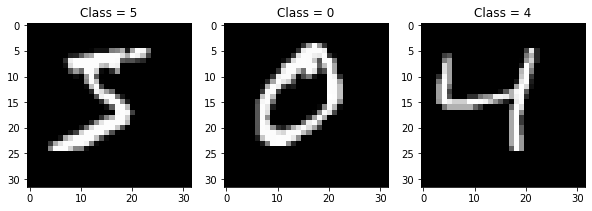

In [16]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(x_train1[i][...,0], cmap='gray')
    plt.title('Class = {}'.format(y_train[i]))

# 4. Model Build

In [23]:
mobilenet_param = {'inputs': 32,
                  'channels': 1,
                  'dens_num': 1000,
                'drop_rate': 0.5,
                'output_count': 10,
                'output_act': 'softmax'}
model = mobilenet_2D(mobilenet_param)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization_81 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
activation_81 (Activation)   (None, 16, 16, 32)        0         
_________________________________________________________________
depthwise_conv2d_39 (Depthwi (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization_82 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
activation_82 (Activation)   (None, 16, 16, 32)        0   

In [27]:
model = tf.keras.applications.mobilenet.MobileNet(
    input_shape=None, alpha=1.0, depth_multiplier=1, dropout=0.001,
    include_top=True, weights=None, input_tensor=(32,32,1), pooling=None,
    classes=10, classifier_activation='softmax')
model.summary()


ValueError: Unexpectedly found an instance of type `<class 'tuple'>`. Expected a symbolic tensor instance.

# 4. Training

In [24]:
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.Adam(lr=1e-5), metrics=['acc'])

In [25]:
callback_list = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
                         keras.callbacks.ModelCheckpoint(filepath=os.path.join('2d_model.h5'),
                                                         monitor='val_accuracy', save_best_only=True),
                         keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)]

history = model.fit(x_train1, y_train1, epochs=50, batch_size=32, 
                    validation_data=(x_test1, y_test1),
                    callbacks=callback_list, shuffle=True)

Epoch 1/50


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model_3/conv2d_42/Conv2D (defined at <ipython-input-25-6b0b15f0d6e7>:6) ]] [Op:__inference_train_function_12939]

Function call stack:
train_function
